## Setup & Imports

In [29]:
!pip install numpy nibabel matplotlib pandas torch scipy tqdm plotly optuna SimpleITK hd-bet

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installi


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

from scipy.ndimage import rotate
import optuna

from optuna.pruners import MedianPruner
from torch.cuda.amp import autocast, GradScaler

import SimpleITK as sitk

import subprocess

from tqdm import tqdm

d:\Projects\tbi-lesion-segmentation\aims_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load NIfTI Files

In [3]:
# Define data path and list NIfTI (.nii) files
data_path = "F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles"
file_list = sorted([f for f in os.listdir(data_path) if f.endswith('.nii')])

print(f"Found {len(file_list)} nii files")
print(file_list[:10])


Found 332 nii files
['scan_0001_Lesion.nii', 'scan_0001_T1.nii', 'scan_0004_Lesion.nii', 'scan_0004_T1.nii', 'scan_0007_Lesion.nii', 'scan_0007_T1.nii', 'scan_0016_Lesion.nii', 'scan_0016_T1.nii', 'scan_0017_Lesion.nii', 'scan_0017_T1.nii']


## Read Sample NIfTI File

- .nii file are 3d images
- consider slices as the 2d images stacked together to create a 3d one

In [4]:
# Load a sample NIfTI file
nii_file = os.path.join(data_path, file_list[1])
img = nib.load(nii_file)
img_data = img.get_fdata()

print(f"Loaded file: {file_list[1]}")
print(f"Image shape: {img_data.shape}")

Loaded file: scan_0001_T1.nii
Image shape: (256, 256, 256)


### VIsualizing Slices

Medical image slices (like MRI or CT scans) are displayed in grayscale, where pixel values are mapped to shades from black (low intensity) to white (high intensity).

*   **Black Areas:** Typically represent regions with very low signal intensity. This includes the background (air), air-filled cavities, and certain tissue types depending on the scan method (e.g., bone or CSF in some MRI sequences, air in CT).
*   **White/Brighter Areas:** Represent regions with high signal intensity. This includes dense tissues (like bone in CT), certain tissue properties in MRI (like fat in T1-weighted or fluid/edema in T2-weighted), or areas with contrast agent uptake.

The contrast between dark and bright areas helps visualize

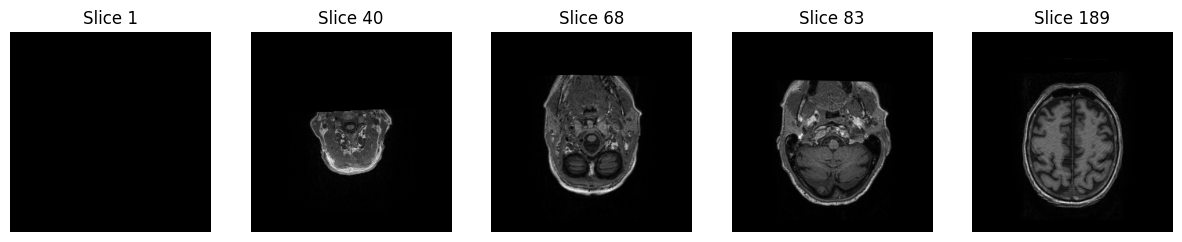

In [5]:
num_slices = 5
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Random unique slice indices from the axial dimension (depth)
slice_indices = np.random.choice(img_data.shape[2], size=num_slices, replace=False)
slice_indices = np.sort(slice_indices)

for i, slice_idx in enumerate(slice_indices):
    slice_img = img_data[:, :, slice_idx].T
    axes[i].imshow(slice_img, cmap='gray', origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.show()

### Visualizing T1 Image with Lesion Mask

This code block loads both a T1-weighted MRI image and its corresponding lesion segmentation mask for the same scan. It then displays a series of slices from a specified range, overlaying the lesion mask on top of the T1 image to highlight the location and extent of the lesion.

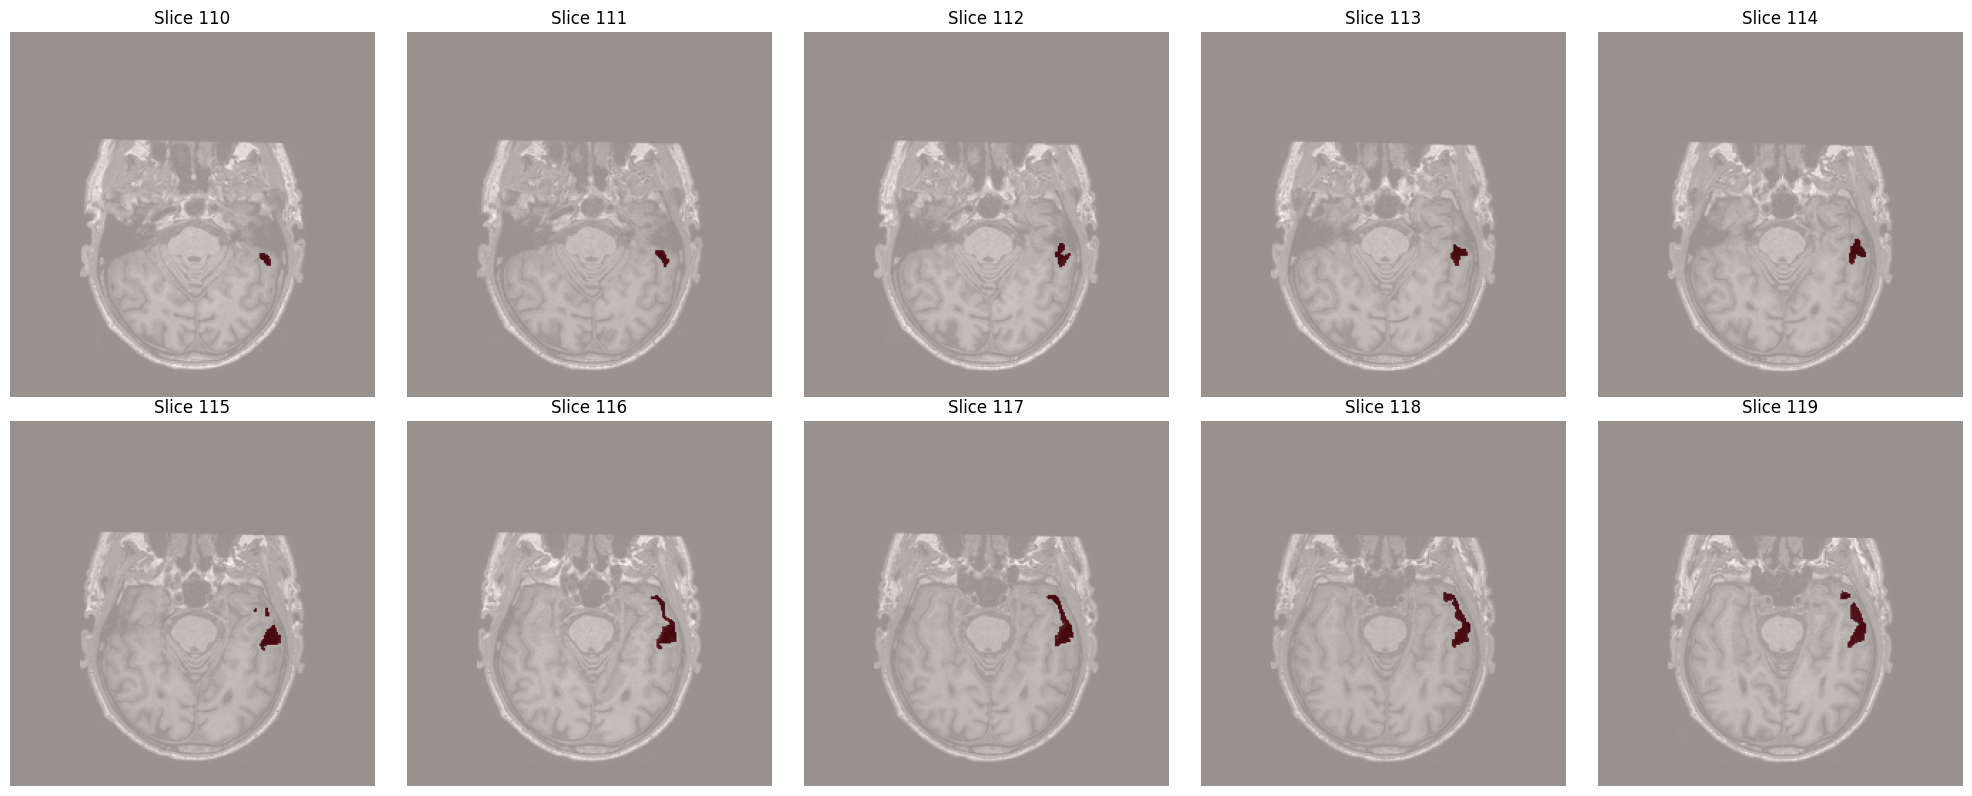

In [6]:
# Load both the T1 image and the Lesion mask
t1_file = os.path.join(data_path, 'scan_0001_T1.nii')
lesion_file = os.path.join(data_path, 'scan_0001_Lesion.nii')

t1_img = nib.load(t1_file).get_fdata()
lesion_img = nib.load(lesion_file).get_fdata()

# User-defined slice range
start_slice = 110
num_slices = 10

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_slices):
    slice_idx = start_slice + i
    t1_slice = t1_img[:, :, slice_idx].T
    lesion_slice = lesion_img[:, :, slice_idx].T

    axes[i].imshow(t1_slice, cmap='gray', origin='lower')
    axes[i].imshow(lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Visualizing Coronal and Sagittal Slices

This code block demonstrates how to extract and visualize slices from the 3D image data (`img_data`) along planes other than the standard axial view. Specifically, it shows how to display a coronal slice and a sagittal slice from the middle of the image volume.

*   Medical 3D images can be viewed as stacks of 2D slices along different orientations:
    *   **Axial (or Transverse) slices:** Imagine slicing the body horizontally, like slicing a loaf of bread. These separate the top from the bottom.
    *   **Coronal slices:** Imagine slicing the body vertically from side-to-side, separating the front (anterior) from the back (posterior). This code visualizes a coronal slice.
    *   **Sagittal slices:** Imagine slicing the body vertically from front to back, separating the left side from the right side. This code visualizes a sagittal slice.

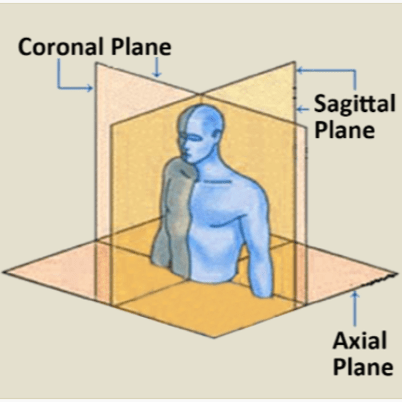

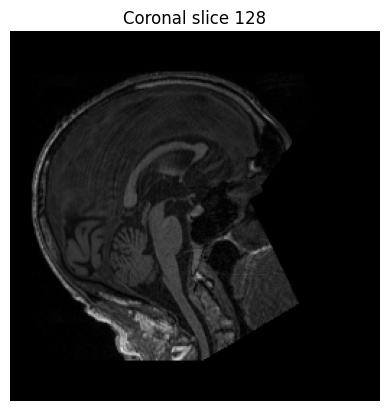

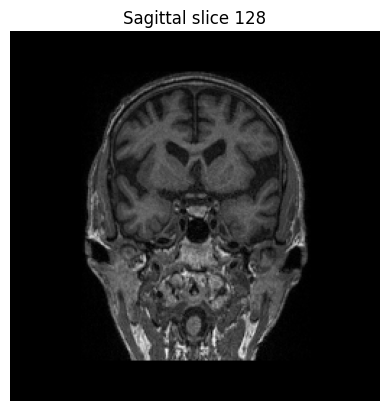

In [7]:
# Coronal slice (YZ plane)
slice_idx = img_data.shape[0] // 2
coronal_slice = img_data[slice_idx, :, :].T
plt.imshow(coronal_slice, cmap='gray', origin='lower')
plt.title(f"Coronal slice {slice_idx}")
plt.axis('off')
plt.show()

# Sagittal slice (XZ plane)
slice_idx = img_data.shape[1] // 2
sagittal_slice = img_data[:, slice_idx, :].T
plt.imshow(sagittal_slice, cmap='gray', origin='lower')
plt.title(f"Sagittal slice {slice_idx}")
plt.axis('off')
plt.show()


### Image Intensity Distribution and Non-Zero Voxels

- This code block analyzes the distribution of intensity values within the entire 3D image and calculates the proportion of voxels (3D pixels) that have non-zero intensity values.
- This helps understand the overall characteristics of the image data, such as the range of intensities present and how much of the image volume is not just background.

In [8]:
def get_lesion_percentage(lesion_path):
    lesion_img = nib.load(lesion_path).get_fdata()
    lesion_voxels = np.count_nonzero(lesion_img)
    total_voxels = lesion_img.size
    return lesion_voxels, total_voxels

# List all lesion files
lesion_files = sorted([f for f in os.listdir(data_path) if f.endswith('_Lesion.nii')])

# Overall percentage
total_lesion_voxels = 0
total_voxels = 0
for lesion_file in lesion_files:
    lesion_path = os.path.join(data_path, lesion_file)
    lesion_vox, vox = get_lesion_percentage(lesion_path)
    total_lesion_voxels += lesion_vox
    total_voxels += vox
overall_percentage = 100 * total_lesion_voxels / total_voxels
print(f"Overall lesion percentage: {overall_percentage:.2f}%")

# Per-scan percentage for a given range
start_idx = 10  # Change as needed
num_scans = 5  # Change as needed
for i in range(start_idx, min(start_idx + num_scans, len(lesion_files))):
    lesion_file = lesion_files[i]
    lesion_path = os.path.join(data_path, lesion_file)
    lesion_vox, vox = get_lesion_percentage(lesion_path)
    percentage = 100 * lesion_vox / vox
    print(f"{lesion_file}: {percentage:.2f}% lesion voxels")

Overall lesion percentage: 0.05%
scan_0029_Lesion.nii: 0.02% lesion voxels
scan_0033_Lesion.nii: 0.00% lesion voxels
scan_0036_Lesion.nii: 0.03% lesion voxels
scan_0038_Lesion.nii: 0.03% lesion voxels
scan_0040_Lesion.nii: 0.00% lesion voxels


## Preprocessing pipeline

### Look for noise scans (!!!SKIP THIS STEP!!!)

First visualize some scans

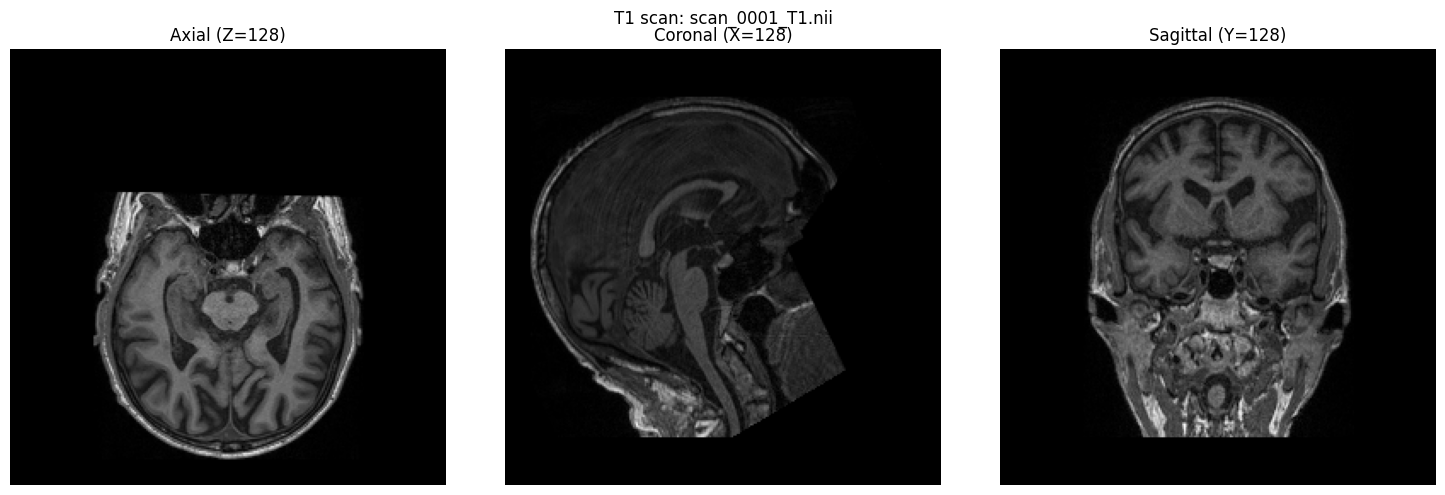

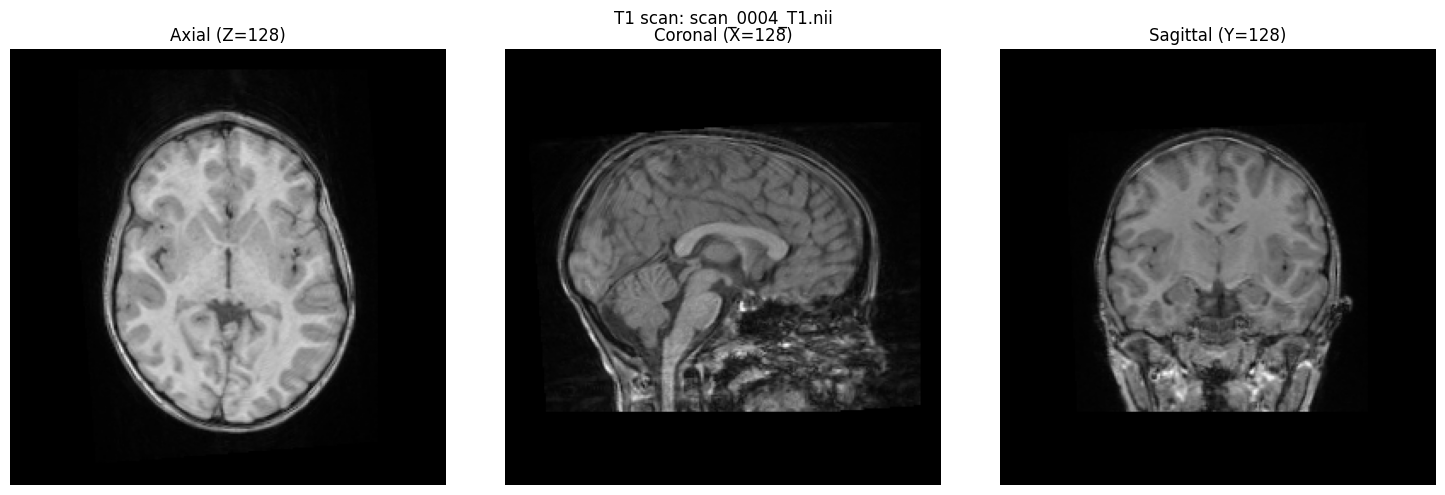

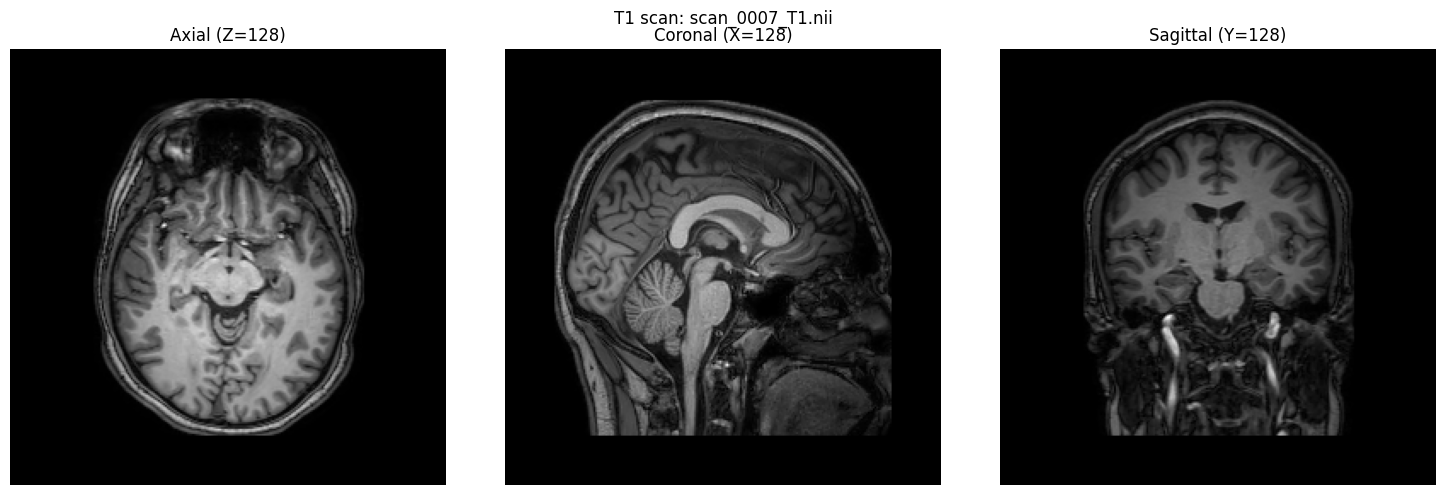

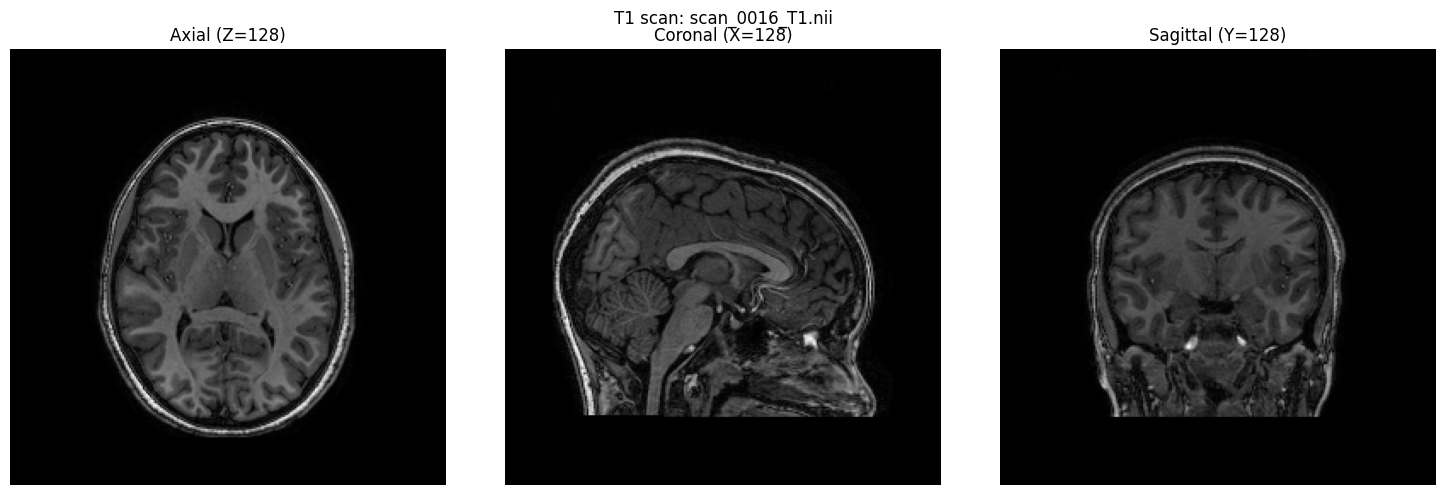

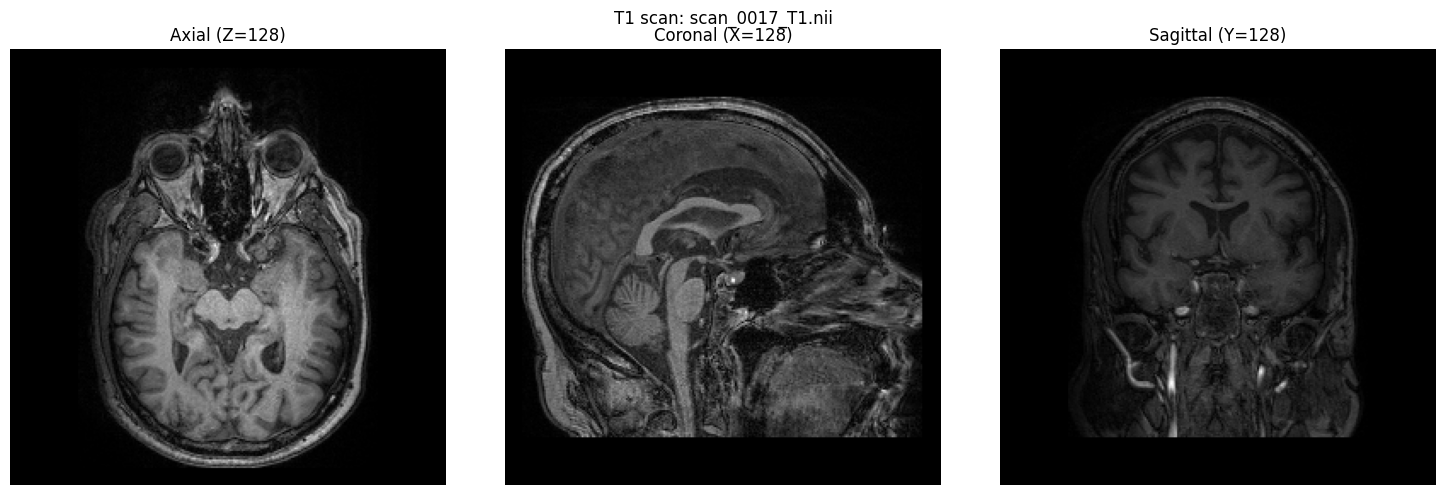

In [9]:
start_idx = 0  
num_scans = 5  

t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

for i in range(start_idx, min(start_idx + num_scans, len(t1_files))):
    t1_file = t1_files[i]
    t1_path = os.path.join(data_path, t1_file)
    t1_img = nib.load(t1_path).get_fdata()
    
    # Show central slice in each plane (axial, coronal, sagittal)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(t1_img[:, :, t1_img.shape[2] // 2].T, cmap='gray', origin='lower')
    axes[0].set_title(f'Axial (Z={t1_img.shape[2] // 2})')
    axes[0].axis('off')
    
    axes[1].imshow(t1_img[t1_img.shape[0] // 2, :, :].T, cmap='gray', origin='lower')
    axes[1].set_title(f'Coronal (X={t1_img.shape[0] // 2})')
    axes[1].axis('off')
    
    axes[2].imshow(t1_img[:, t1_img.shape[1] // 2, :].T, cmap='gray', origin='lower')
    axes[2].set_title(f'Sagittal (Y={t1_img.shape[1] // 2})')
    axes[2].axis('off')
    
    plt.suptitle(f"T1 scan: {t1_file}")
    plt.tight_layout()

Use MRQY to find stats about the scans

In [10]:
# output_folder = 'mrqy_results'
# os.makedirs(output_folder, exist_ok=True)

# # Only include T1 scans for MRQY QC
# t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])
# t1_paths = [os.path.join(data_path, f) for f in t1_files]

# print("Running MRQy on selected T1 scans...")

# for t1_path in t1_paths:
#     print(f"Processing: {os.path.basename(t1_path)}")
#     cmd = ["python", "-m", "mrqy.QC", output_folder, t1_path]
#     result = subprocess.run(cmd, capture_output=True, text=True)
#     print(result.stdout)
#     if result.stderr:
#         print("Warnings/errors:")
#         print(result.stderr)

# print(f"\nMRQy results saved in folder: {output_folder}")

### Bias field correction

Function for bias field correction using SimpleITK.

In [11]:
def bias_field_correction(input_path, output_path=None):
    """
    Perform N4 bias field correction on a NIfTI image.
    
    Parameters:
    input_path (str): Path to input NIfTI file
    output_path (str): Path to save corrected image (optional)
    
    Returns:
    numpy.ndarray: Bias-corrected image data
    """
    # Read the image
    image = sitk.ReadImage(input_path)
    
    # Convert to float32 for processing
    image = sitk.Cast(image, sitk.sitkFloat32)
    
    # Create mask (optional - helps with convergence)
    # Use Otsu thresholding to create a brain mask
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    mask = otsu_filter.Execute(image)

    # Apply N4 bias field correction
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([4] * 4) 
    corrected_image = corrector.Execute(image, mask)
    
    # Save corrected image if output path provided
    if output_path:
        sitk.WriteImage(corrected_image, output_path)
        print(f"Bias-corrected image saved to: {output_path}")
    
    # Convert back to numpy array
    corrected_array = sitk.GetArrayFromImage(corrected_image)
    
    return corrected_array

Apply bias field correction to all the scans in the directory

In [ ]:
# Create output directory for corrected images
corrected_output_dir = os.path.join(data_path, "corrected_T1_scans")
os.makedirs(corrected_output_dir, exist_ok=True)

# Get all T1 files
t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

# Limit to first 15 images only
t1_files = t1_files[:15]

print(f"Found {len(t1_files)} T1 scans to process")

# Process each T1 scan
for t1_file in tqdm(t1_files, desc="Processing T1 scans"):
    input_path = os.path.join(data_path, t1_file)

    # Create output filename (add "bias_corrected" before file extension)
    base_name = t1_file.replace('.nii', '')
    output_filename = f"{base_name}_bias_corrected.nii"
    output_path = os.path.join(corrected_output_dir, output_filename)
    
    # Skip if corrected file already exists
    if os.path.exists(output_path):
        print(f"⏭️ Skipping {t1_file} - corrected file already exists")
        continue
    
    try:
        print(f"Processing: {t1_file}")
        corrected_data = bias_field_correction(input_path, output_path)
        print(f"✓ Completed: {output_filename}")
    except Exception as e:
        print(f"✗ Error processing {t1_file}: {str(e)}")

print(f"\nBias field correction completed. Corrected images

Found 15 T1 scans to process


Processing T1 scans:   0%|          | 0/15 [00:00<?, ?it/s]

Processing: scan_0001_T1.nii


Processing T1 scans:   7%|▋         | 1/15 [00:18<04:12, 18.00s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0001_T1_bias_corrected.nii
✓ Completed: scan_0001_T1_bias_corrected.nii
Processing: scan_0004_T1.nii


Processing T1 scans:  13%|█▎        | 2/15 [00:36<03:54, 18.07s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0004_T1_bias_corrected.nii
✓ Completed: scan_0004_T1_bias_corrected.nii
Processing: scan_0007_T1.nii


Processing T1 scans:  20%|██        | 3/15 [00:56<03:49, 19.11s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0007_T1_bias_corrected.nii
✓ Completed: scan_0007_T1_bias_corrected.nii
Processing: scan_0016_T1.nii


Processing T1 scans:  27%|██▋       | 4/15 [01:10<03:10, 17.28s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0016_T1_bias_corrected.nii
✓ Completed: scan_0016_T1_bias_corrected.nii
Processing: scan_0017_T1.nii


Processing T1 scans:  33%|███▎      | 5/15 [01:31<03:04, 18.43s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0017_T1_bias_corrected.nii
✓ Completed: scan_0017_T1_bias_corrected.nii
Processing: scan_0019_T1.nii


Processing T1 scans:  40%|████      | 6/15 [01:49<02:44, 18.28s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0019_T1_bias_corrected.nii
✓ Completed: scan_0019_T1_bias_corrected.nii
Processing: scan_0020_T1.nii


Processing T1 scans:  47%|████▋     | 7/15 [02:06<02:23, 17.98s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0020_T1_bias_corrected.nii
✓ Completed: scan_0020_T1_bias_corrected.nii
Processing: scan_0021_T1.nii


Processing T1 scans:  53%|█████▎    | 8/15 [02:33<02:24, 20.71s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0021_T1_bias_corrected.nii
✓ Completed: scan_0021_T1_bias_corrected.nii
Processing: scan_0024_T1.nii


Processing T1 scans:  60%|██████    | 9/15 [03:04<02:23, 23.89s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0024_T1_bias_corrected.nii
✓ Completed: scan_0024_T1_bias_corrected.nii
Processing: scan_0028_T1.nii


Processing T1 scans:  67%|██████▋   | 10/15 [03:30<02:03, 24.72s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0028_T1_bias_corrected.nii
✓ Completed: scan_0028_T1_bias_corrected.nii
Processing: scan_0029_T1.nii


Processing T1 scans:  73%|███████▎  | 11/15 [03:55<01:38, 24.72s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0029_T1_bias_corrected.nii
✓ Completed: scan_0029_T1_bias_corrected.nii
Processing: scan_0033_T1.nii


Processing T1 scans:  80%|████████  | 12/15 [04:11<01:06, 22.10s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0033_T1_bias_corrected.nii
✓ Completed: scan_0033_T1_bias_corrected.nii
Processing: scan_0036_T1.nii


Processing T1 scans:  87%|████████▋ | 13/15 [04:26<00:40, 20.07s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0036_T1_bias_corrected.nii
✓ Completed: scan_0036_T1_bias_corrected.nii
Processing: scan_0038_T1.nii


Processing T1 scans:  93%|█████████▎| 14/15 [04:51<00:21, 21.52s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0038_T1_bias_corrected.nii
✓ Completed: scan_0038_T1_bias_corrected.nii
Processing: scan_0040_T1.nii


Processing T1 scans: 100%|██████████| 15/15 [05:21<00:00, 21.41s/it]

Bias-corrected image saved to: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans\scan_0040_T1_bias_corrected.nii
✓ Completed: scan_0040_T1_bias_corrected.nii

Bias field correction completed. Corrected images saved in: F:/AIMS_TBI_Lesion_Segmentation/ChallengeFiles\corrected_T1_scans


Visualize the impact of bias correction

In [14]:
def visualize_bias_correction_comparison(original_path, corrected_path, slice_idx=None):
    """
    Compare original and bias-corrected images side by side
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    corrected_img = nib.load(corrected_path).get_fdata()
    
    # Use middle slice if not specified
    if slice_idx is None:
        slice_idx = original_img.shape[2] // 2
    
    # Extract slices
    original_slice = original_img[:, :, slice_idx].T
    corrected_slice = corrected_img[:, :, slice_idx].T
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original image - different views
    axes[0, 0].imshow(original_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, 0].set_title(f'Original - Axial (slice {slice_idx})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_img[original_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[0, 1].set_title('Original - Coronal')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(original_img[:, original_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[0, 2].set_title('Original - Sagittal')
    axes[0, 2].axis('off')
    
    # Corrected image - different views  
    axes[1, 0].imshow(corrected_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, 0].set_title(f'Bias Corrected - Axial (slice {slice_idx})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_img[corrected_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[1, 1].set_title('Bias Corrected - Coronal')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(corrected_img[:, corrected_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[1, 2].set_title('Bias Corrected - Sagittal')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot intensity histograms for comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original histogram
    axes[0].hist(original_img[original_img > 0].flatten(), bins=100, alpha=0.7, color='blue', density=True)
    axes[0].set_title('Original Image - Intensity Distribution')
    axes[0].set_xlabel('Intensity')
    axes[0].set_ylabel('Density')
    
    # Corrected histogram
    axes[1].hist(corrected_img[corrected_img > 0].flatten(), bins=100, alpha=0.7, color='red', density=True)
    axes[1].set_title('Bias Corrected Image - Intensity Distribution')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_bias_correction_quality(original_path, corrected_path):
    """
    Evaluate the quality of bias field correction using quantitative metrics
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    corrected_img = nib.load(corrected_path).get_fdata()
    
    # Create brain mask (non-zero voxels)
    brain_mask = original_img > 0
    
    # Calculate metrics
    original_brain = original_img[brain_mask]
    corrected_brain = corrected_img[brain_mask]
    
    # 1. Coefficient of Variation (CV) - lower is better
    original_cv = np.std(original_brain) / np.mean(original_brain)
    corrected_cv = np.std(corrected_brain) / np.mean(corrected_brain)
    
    # 2. Signal-to-Noise Ratio improvement
    original_snr = np.mean(original_brain) / np.std(original_brain)
    corrected_snr = np.mean(corrected_brain) / np.std(corrected_brain)
    
    # 3. Intensity uniformity in homogeneous regions
    # Use central region as proxy for white matter
    center_z = original_img.shape[2] // 2
    center_region = original_img[80:120, 80:120, center_z-5:center_z+5]
    center_region_corrected = corrected_img[80:120, 80:120, center_z-5:center_z+5]
    
    center_region = center_region[center_region > 0]
    center_region_corrected = center_region_corrected[center_region_corrected > 0]
    
    original_uniformity = np.std(center_region) / np.mean(center_region) if len(center_region) > 0 else 0
    corrected_uniformity = np.std(center_region_corrected) / np.mean(center_region_corrected) if len(center_region_corrected) > 0 else 0
    
    print("=== Bias Correction Quality Assessment ===")
    print(f"Coefficient of Variation (CV):")
    print(f"  Original: {original_cv:.4f}")
    print(f"  Corrected: {corrected_cv:.4f}")
    print(f"  Improvement: {((original_cv - corrected_cv) / original_cv * 100):.2f}%")
    print()
    
    print(f"Signal-to-Noise Ratio (SNR):")
    print(f"  Original: {original_snr:.4f}")
    print(f"  Corrected: {corrected_snr:.4f}")
    print(f"  Improvement: {((corrected_snr - original_snr) / original_snr * 100):.2f}%")
    print()
    
    print(f"Regional Uniformity (Central Region CV):")
    print(f"  Original: {original_uniformity:.4f}")
    print(f"  Corrected: {corrected_uniformity:.4f}")
    print(f"  Improvement: {((original_uniformity - corrected_uniformity) / original_uniformity * 100):.2f}%")
    
    # Overall assessment
    print("\n=== Overall Assessment ===")
    improvements = 0
    if corrected_cv < original_cv:
        improvements += 1
        print("✓ Reduced coefficient of variation")
    if corrected_snr > original_snr:
        improvements += 1
        print("✓ Improved signal-to-noise ratio")
    if corrected_uniformity < original_uniformity:
        improvements += 1
        print("✓ Improved regional uniformity")
    
    if improvements >= 2:
        print("🎉 Bias correction appears SUCCESSFUL!")
    elif improvements == 1:
        print("⚠️ Bias correction shows MODERATE improvement")
    else:
        print("❌ Bias correction may have FAILED or made things worse")



Comparing: scan_0036_T1.nii


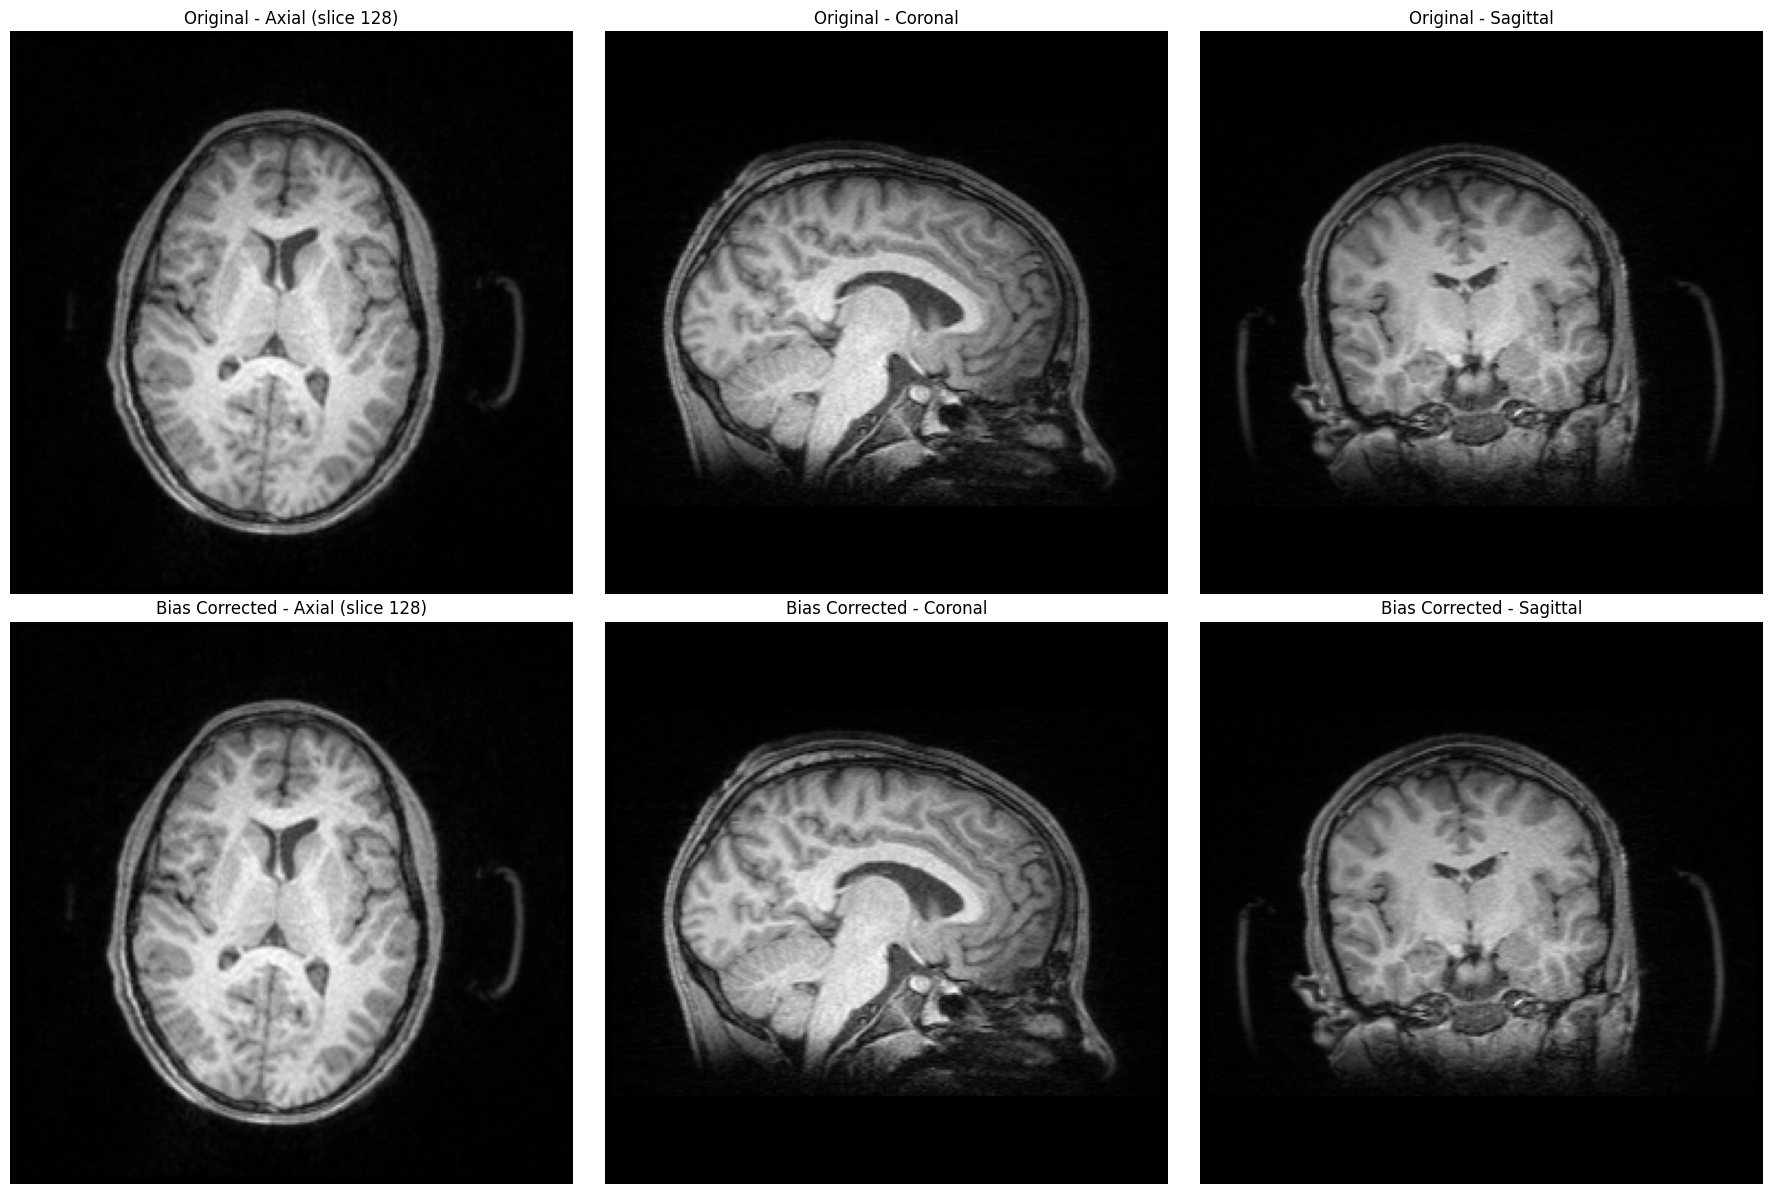

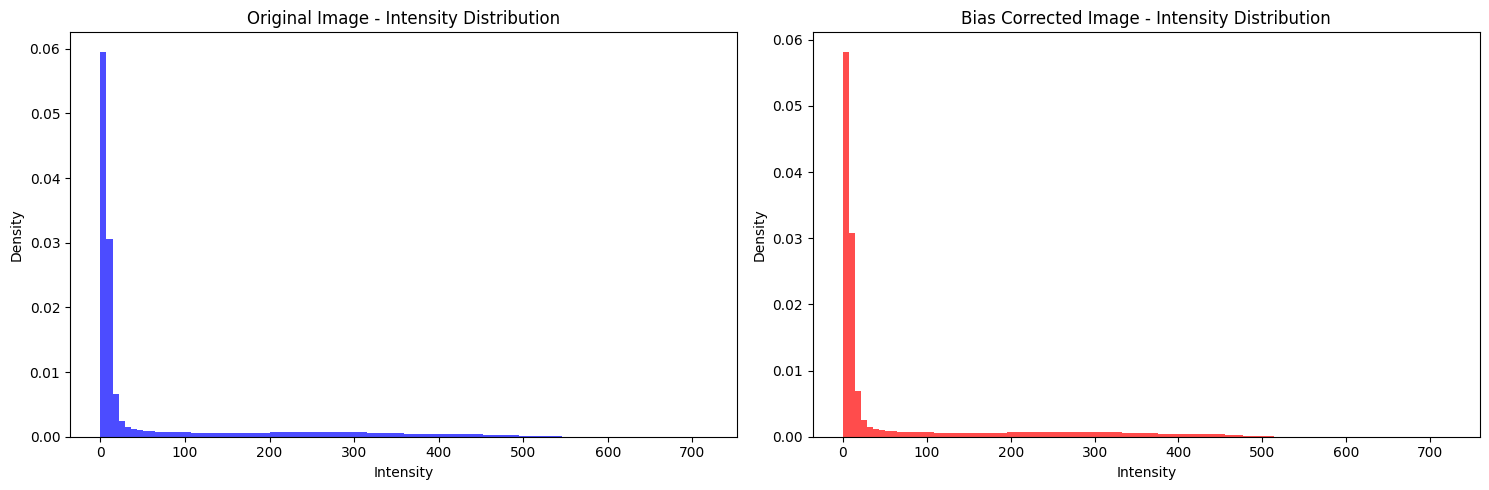

=== Bias Correction Quality Assessment ===
Coefficient of Variation (CV):
  Original: 1.7301
  Corrected: 1.7042
  Improvement: 1.50%

Signal-to-Noise Ratio (SNR):
  Original: 0.5780
  Corrected: 0.5868
  Improvement: 1.52%

Regional Uniformity (Central Region CV):
  Original: 0.1969
  Corrected: 0.1974
  Improvement: -0.21%

=== Overall Assessment ===
✓ Reduced coefficient of variation
✓ Improved signal-to-noise ratio
🎉 Bias correction appears SUCCESSFUL!


In [28]:
# Example usage for first corrected image
t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

idx = 12

if t1_files:
    original_file = os.path.join(data_path, t1_files[idx])
    corrected_file = os.path.join(corrected_output_dir, t1_files[idx].replace('.nii', '_bias_corrected.nii'))
    
    if os.path.exists(corrected_file):
        print(f"Comparing: {t1_files[idx]}")
        visualize_bias_correction_comparison(original_file, corrected_file)
        evaluate_bias_correction_quality(original_file, corrected_file)
    else:
        print("Corrected file not found. Run bias correction first.")

### Skull Stripping using HD-BET

Define the function to perform skull stripping using HD-BET.

In [ ]:
def skull_strip_with_hdbet(input_path, output_path, use_gpu=True, mode="fast"):
    """
    Perform skull stripping using HD-BET
    
    Parameters:
    input_path (str): Path to input NIfTI file
    output_path (str): Path to save skull-stripped image
    use_gpu (bool): Whether to use GPU acceleration
    mode (str): Processing mode - "fast" or "accurate"
    
    Returns:
    bool: True if successful, False otherwise
    """
    try:
        # HD-BET command
        cmd = ["hd-bet", "-i", input_path, "-o", output_path]
        
        # Add GPU flag if available
        if use_gpu:
            cmd.extend(["-device", "gpu"])
        else:
            cmd.extend(["-device", "cpu"])
        
        # Add mode flag
        if mode == "fast":
            cmd.extend(["-mode", "fast"])
        elif mode == "accurate":
            cmd.extend(["-mode", "accurate"])
        else:
            print(f"Warning: Unknown mode '{mode}', using default")
        
        # Run HD-BET
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        
        print(f"✓ Skull stripping completed ({mode} mode): {os.path.basename(output_path)}")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Error during skull stripping: {e}")
        print(f"Error output: {e.stderr}")
        return False
    except Exception as e:
        print(f"✗ Unexpected error: {str(e)}")
        return False

In [ ]:
# Create output directory for skull-stripped images
skull_stripped_output_dir = os.path.join(data_path, "skull_stripped_T1_scans")
os.makedirs(skull_stripped_output_dir, exist_ok=True)

# Get all bias-corrected files
corrected_files = sorted([f for f in os.listdir(corrected_output_dir) if f.endswith('_bias_corrected.nii')])

print(f"Found {len(corrected_files)} bias-corrected T1 scans to process")

# Check GPU availability
gpu_available = torch.cuda.is_available()
print(f"GPU available: {gpu_available}")

# Process each bias-corrected scan
successful_count = 0
failed_count = 0

for corrected_file in tqdm(corrected_files, desc="Skull stripping T1 scans"):
    input_path = os.path.join(corrected_output_dir, corrected_file)
    
    # Create output filename (replace "bias_corrected" with "skull_stripped")
    base_name = corrected_file.replace('_bias_corrected.nii', '')
    output_filename = f"{base_name}_skull_stripped.nii.gz"  # HD-BET outputs .nii.gz
    output_path = os.path.join(skull_stripped_output_dir, output_filename)
    
    # Skip if skull-stripped file already exists
    if os.path.exists(output_path):
        print(f"⏭️ Skipping {corrected_file} - skull-stripped file already exists")
        continue
    
    print(f"Processing: {corrected_file}")
    
    # Perform skull stripping
    success = skull_strip_with_hdbet(input_path, output_path, use_gpu=gpu_available)
    
    if success:
        successful_count += 1
    else:
        failed_count += 1

print(f"\n=== Skull Stripping Summary ===")
print(f"✓ Successfully processed: {successful_count} scans")
print(f"✗ Failed: {failed_count} scans")
print(f"Skull-stripped images saved in: {skull_stripped_output_dir}")

Found 15 bias-corrected T1 scans to process
GPU available: False


Skull stripping T1 scans:   0%|          | 0/15 [00:00<?, ?it/s]

Processing: scan_0001_T1_bias_corrected.nii
